**Table of contents**<a id='toc0_'></a>    
- [Problem 1](#toc1_)    
  - [1(a)](#toc1_1_)    
  - [1(a)-2](#toc1_2_)    
  - [1(b)](#toc1_3_)    
  - [1(c)](#toc1_4_)    
  - [1(d)](#toc1_5_)    
  - [1(e)](#toc1_6_)    
  - [Compare estimations from different methods](#toc1_7_)    
- [Problem 2](#toc2_)    
  - [2(a)](#toc2_1_)    
  - [2(b)](#toc2_2_)    
  - [2(c)](#toc2_3_)    
  - [2(d)](#toc2_4_)    
  - [2(e)](#toc2_5_)    
- [3: use nested logit demand and FOC..](#toc3_)    
  - [3(a)](#toc3_1_)    
  - [3(a)-1: check fully competition context](#toc3_2_)    
  - [3(b): a merge between 1 and 2](#toc3_3_)    
  - [3(d): when all firms are colluding](#toc3_4_)    
    - [3(d)-1: Direct maximize profit](#toc3_4_1_)    
    - [3(d)-2 use FOC to solve Nash](#toc3_4_2_)    
- [4: redo 3 with MultiNomial Logit](#toc4_)    
  - [3(a)](#toc4_1_)    
  - [3(b)](#toc4_2_)    
  - [3(c) and 3(d)](#toc4_3_)    
    - [Answer for 3(c):](#toc4_3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from functions_homework1 import *

import warnings
warnings.filterwarnings("ignore")

global demand_df, c_jt_dic, PARAMS, alpha, Temp_t, data, params_IV, nest_params_IV
global p_jt_dic, s_jt_dic, s_jmidgt_dic, s_gt_dic

# <a id='toc1_'></a>[Problem 1: MNL demand](#toc0_)
## <a id='toc1_1_'></a>[1(a) Run OLS for MNL](#toc0_)
In this part I reg $ln(s_{jt}/s_{0t})$ to $X_{jt},p_{jt}$, no constant. This means I treat $\xi_j$ as noise in regression with mean 0. In 1(b) I take them as constants.


In [2]:
Dic_para_q1 = dict()
Dic_para_q2q3 = dict()
# Load the data
data = pd.read_csv('product_data.csv')
data = prepare_data(data)

# Prepare the design matrix X and dependent variable y
# X = data[['price', 'sugar', 'caffeine', 'Diet', 'Regular']]
# y = data['log_odds']

# # Fit the model
# model = sm.OLS(y, X)
# model_results = model.fit()

model_results = run_2sls(data,['log_odds'],['price', 'sugar', 'caffeine', 'Diet', 'Regular'],[],[])

# Print the results
print(model_results.summary())

params_ols = get_parameters(model_results, nested=False, print_results=False)
Dic_para_q1['OLS'] = params_ols

                          IV2SLS Regression Results                           
Dep. Variable:               log_odds   R-squared:                       0.885
Model:                         IV2SLS   Adj. R-squared:                  0.884
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Sat, 21 Sep 2024                                         
Time:                        11:35:24                                         
No. Observations:                1000                                         
Df Residuals:                     995                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price         -1.6261      0.021    -77.352      0.0

## <a id='toc1_2_'></a>[1(a)-2: Run another OLS, adding j-specific time-invariant constants as j-firm specific shocks. No significant change in estimations.](#toc0_)
In this part I reg $ln(s_{jt}/s_{0t})$ to $X_{jt},p_{jt}$, no constant and 9 dummies for each j (drop ID_1). This means I treat $\xi_j$ as fixed within periods in regression.

In [3]:
# ID_dummies = pd.get_dummies(data['product_ID'], prefix='ID').astype(int)
# ID_dummies = ID_dummies.drop('ID_1', axis=1)

# X = pd.concat([X, ID_dummies], axis=1)
# y = data['log_odds']

# # Fit the model
# model = sm.OLS(y, X)
# model_results = model.fit()

# # Print the results
# params_ols_fixed_effect = get_parameters(
#     model_results, nested=False, print_results=True)
# Dic_para_q1['OLS_fixed_effect'] = params_ols_fixed_effect

## <a id='toc1_3_'></a>[1(b): Now use IV for price. Simplity using ingredients prices. ](#toc0_)
The main concern of endogeneity is that $P_j$ is affected by $\xi_j$, say brand effect.

So use price for ingredients: sugar and caffine price.

They are valid IV, since firm j's ingredients' price certainly affect price via cost, but they have little relationship with firm j's brand effect. (using other firms' ingredients price are not valid since they are not related with firm j's price)

In [4]:
iv_results = run_2sls(data,['log_odds'],['price', 'sugar', 'caffeine', 'Diet', 'Regular'],['caffeine_extract_price','corn_syrup_price'],['price'])

# Print the results
params_IV = get_parameters(iv_results, nested=False, print_results=True)
Dic_para_q1['IV'] = params_IV

alpha (price): -1.4104
beta1 (sugar): 1.4277
beta2 (caffeine): 1.3821
gamma_D (Diet): -2.5573
gamma_R (Regular): -6.6182


## <a id='toc1_4_'></a>[1(c): Calculate own price derivative and own price elasticity](#toc0_)
Let $M=\sum_{k\neq j} exp(\delta_k)+1$, then $\frac{\partial s_{jt}}{\partial p_{jt}}=\frac{Mexp(\delta_{jt})}{(M+exp(\delta_{jt}))^2}\alpha=\alpha s_{jt}(1-s_{jt})$

In [5]:
# Function to calculate own-price derivative
def own_price_derivative(alpha, s_jt):
    return alpha * s_jt * (1 - s_jt)

# Function to calculate own-price elasticity
def own_price_elasticity(alpha, p_jt, s_jt):
    return alpha * p_jt * (1 - s_jt)

# Given df and params, calculate the own-price derivative and elasticity, Under any MNL setting
# return mean elasticity for Regular and Diet drinks, and modified df
def own_PD_PE(df, params):
    """take alpha and call the function, return the results"""
    data = df.copy()
    # Calculate own-price derivatives and elasticities
    alpha = params['alpha']
    data['own_price_derivative'] = own_price_derivative(
        alpha, data['market_share'])
    data['own_price_elasticity'] = own_price_elasticity(
        alpha, data['price'], data['market_share'])

    # Calculate mean elasticities for Regular and Diet drinks
    mean_elasticity_regular = data[data['nest']
                                   == 'Regular']['own_price_elasticity'].mean()
    mean_elasticity_diet = data[data['nest'] ==
                                'Diet']['own_price_elasticity'].mean()

    print(
        f"Mean own-price elasticity for Regular drinks: {mean_elasticity_regular:.4f}")
    print(
        f"Mean own-price elasticity for Diet drinks: {mean_elasticity_diet:.4f}")

    return [mean_elasticity_regular, mean_elasticity_diet, data]


[mean_elasticity_regular, mean_elasticity_diet,
    data] = own_PD_PE(data, params_IV)
Dic_para_q2q3['own_elasticity_regular_1c'] = mean_elasticity_regular
Dic_para_q2q3['own_elasticity_diet_1c'] = mean_elasticity_diet

Mean own-price elasticity for Regular drinks: -4.2011
Mean own-price elasticity for Diet drinks: -2.9747


## <a id='toc1_5_'></a>[1(d): Calculate cross price derivatives and elasiticity with product 1](#toc0_)
Similarly $\frac{\partial s_{jt}}{\partial p_{1t}}=-\alpha s_{jt}s_{1t}$
Compared to 1(c), cross price derivatives are positive, (own should be certainly negative). Also I expect under MNL setting, cross price elasiticity within group is larger. However here I get wrong directions

In [6]:
# Function to calculate cross-price derivative
def cross_price_derivative(alpha, s_jt, s_it):
    return -alpha * s_jt * s_it

# Function to calculate cross-price elasticity
def cross_price_elasticity(alpha, p_1t, s_jt, s_1t):
    return -alpha * p_1t * s_jt

# Given df and params, calculate the cross-price derivative and elasticity with product 1, Under any MNL setting. return mean elasticity for Regular and Diet drinks, and modified df
def cross_PD_PE(df, params):
    data = df.copy()
    alpha = params['alpha']

    # Get product 1's market share for each time period
    product_1_share = data[data['product_ID'] == 1].set_index('t')[
        'market_share']

    # Calculate cross-price derivatives and elasticities
    data['cross_price_derivative'] = data.apply(lambda row: cross_price_derivative(alpha, row['market_share'], product_1_share[row['t']])
                                                if row['product_ID'] != 1 else np.nan, axis=1)

    data['cross_price_elasticity'] = data.apply(lambda row: cross_price_elasticity(alpha, data.loc[(data['product_ID'] == 1) & (data['t'] == row['t']), 'price'].values[0],
                                                row['market_share'], product_1_share[row['t']])
                                                if row['product_ID'] != 1 else np.nan, axis=1)

    # Calculate mean cross-price elasticities
    mean_cross_elasticity_diet = data[(data['nest'] == 'Diet') & (
        data['product_ID'] != 1)]['cross_price_elasticity'].mean()
    mean_cross_elasticity_regular = data[(data['nest'] == 'Regular') & (
        data['product_ID'] != 1)]['cross_price_elasticity'].mean()

    print(
        f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_cross_elasticity_diet:.4f}")
    print(
        f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_cross_elasticity_regular:.4f}")
    return [mean_cross_elasticity_diet, mean_cross_elasticity_regular, data]


[mean_cross_elasticity_diet, mean_cross_elasticity_regular,
    data] = cross_PD_PE(data, params_IV)
Dic_para_q2q3['cross_elasticity_regular_1d'] = mean_cross_elasticity_regular
Dic_para_q2q3['cross_elasticity_diet_1d'] = mean_cross_elasticity_diet

Mean cross-price elasticity between product 1 and Diet sodas: 0.2054
Mean cross-price elasticity between product 1 and Regular sodas: 0.3867


## <a id='toc1_6_'></a>[1(e):generate Jacobian](#toc0_)
Use the formula that $\frac{\partial s_{jt}}{\partial p_{it}}=-\alpha s_{jt}s_{it}$

In [7]:
def generate_jacobian(time_period, data, params):
    """
    Generate the Jacobian matrix of price derivatives for a given time period.
    I Do need market_share column in the data pd
    Returns: np.array like Jacobian matrix of price derivatives.
    """
    alpha = params['alpha']
    # Filter data for the given time period
    period_data = data[data['t'] == time_period]
    n_products = len(period_data)
    shares = period_data['market_share'].values

    # Initialize the Jacobian matrix
    jacobian = np.zeros((n_products, n_products))

    # Fill in the Jacobian matrix
    for i in range(n_products):
        for j in range(n_products):
            if i == j:
                # Own-price derivative
                s_it = shares[i]
                jacobian[i, i] = own_price_derivative(alpha, s_it)
            else:
                # Cross-price derivative
                s_jt = shares[j]
                s_it = shares[i]
                jacobian[i, j] = cross_price_derivative(alpha, s_jt,  s_it)

    return jacobian


def print_jacobian(data, params_IV):
    # Generate Jacobian for the last time period
    last_period = data['t'].max()
    jacobian_last_period = generate_jacobian(last_period, data, params_IV)
    print(f"Jacobian matrix for period {last_period}:")
    print(np.round(jacobian_last_period, 3))


data_Q1 = data.copy()
print_jacobian(data, params_IV)

Jacobian matrix for period 100:
[[-0.083  0.     0.001  0.002  0.022  0.003  0.039  0.009  0.004  0.003]
 [ 0.    -0.002  0.     0.     0.     0.     0.001  0.     0.     0.   ]
 [ 0.001  0.    -0.014  0.     0.004  0.001  0.006  0.001  0.001  0.001]
 [ 0.002  0.     0.    -0.028  0.007  0.001  0.013  0.003  0.001  0.001]
 [ 0.022  0.     0.004  0.007 -0.261  0.014  0.154  0.033  0.014  0.012]
 [ 0.003  0.     0.001  0.001  0.014 -0.053  0.025  0.005  0.002  0.002]
 [ 0.039  0.001  0.006  0.013  0.154  0.025 -0.348  0.06   0.026  0.023]
 [ 0.009  0.     0.001  0.003  0.033  0.005  0.06  -0.123  0.006  0.005]
 [ 0.004  0.     0.001  0.001  0.014  0.002  0.026  0.006 -0.055  0.002]
 [ 0.003  0.     0.001  0.001  0.012  0.002  0.023  0.005  0.002 -0.049]]


## <a id='toc1_7_'></a>[Compare estimations from different methods](#toc0_)

In [8]:
pd.DataFrame(Dic_para_q1)

,OLS,IV
alpha,-1.626102,-1.410449
beta1,1.528062,1.427685
beta2,1.445800,1.382064
gamma_D,-2.440599,-2.557333
gamma_R,-6.692118,-6.618158


# <a id='toc2_'></a>[Problem 2: Nested Logit Demand](#toc0_)

## <a id='toc2_1_'></a>[2(a) (OLS)IV for Nested logit demand estimation](#toc0_)
If we use OLS I need to estimate 
$$log(odd share_{jt}) = \alpha* price_{jt}+\beta_1* sugar_{jt}+\beta_2 *caffine_{jt}+\gamma_D*Diet_{jt}+\gamma_R*Regular_{jt}+\sigma log(s_{jt \mid g})+\xi_{jt}$$

Now If I'm considering IV, clearly both price and log_within_share is endogenous since they are both affected by brand effects.

- For price, I can still use ingredients price as IV, like before.

- For log_within_share, I create new IV $caffine_{-j,t\mid g},sugar_{-j,t\mid g}$:

    - other firms' (within group) sugar and caffine level affects their competition, so affects firm j's within group share

    - other firms' sugar and caffine level has nothing to do with firm j's brand effects.

In [9]:
Dic_para_q2 = dict()

In [10]:
# Create log_within_share
data['group_share'] = data.groupby(
    ['t', 'nest'])['market_share'].transform('sum')
data['within_group_share'] = data['market_share'] / data['group_share']
data['log_within_share'] = np.log(data['within_group_share'])

# Create sugar_mean_within_group: other products' average sugar content within the same nest
# So I generate sum of sugar content for each nest, and then subtract the sugar content of the product itself
# then divide by the number of other products in the nest
data['others_sugar_mean_within_group'] = data.groupby( ['t', 'nest'])['sugar'].transform('sum') - data['sugar']
data['others_sugar_mean_within_group'] = data['others_sugar_mean_within_group'] / 4

# Create caffeine_mean_within_group: other products' average caffeine content within the same nest
data['others_caffeine_mean_within_group'] = data.groupby( ['t', 'nest'])['caffeine'].transform('sum') - data['caffeine']
data['others_caffeine_mean_within_group'] = data['others_caffeine_mean_within_group'] / 4

# Prepare the exogenous, endogenous, and instrumental variables: form lists
exog_list = ['sugar', 'caffeine', 'Diet', 'Regular']
endog_list = ['price','log_within_share']
IV_list = ['caffeine_extract_price','corn_syrup_price', 'others_sugar_mean_within_group', 'others_caffeine_mean_within_group']

# Perfpoem OLS estimation
ols_model_results = run_2sls(data,['log_odds'],exog_list+endog_list,[],[])
nest_params_ols = get_parameters(
    ols_model_results, nested=True, print_results=False)
Dic_para_q2['nest_OLS'] = nest_params_ols

# Perform 2SLS estimation
iv_model_results = run_2sls(data,['log_odds'],exog_list+endog_list,IV_list,endog_list)
nest_params_IV = get_parameters(
    ols_model_results, nested=True, print_results=False)
Dic_para_q2['nest_params_IV'] = nest_params_IV

In [11]:
nest_params_IV

{'alpha': -0.2532813843353505,
 'beta1': 0.27041110296014864,
 'beta2': 0.2929096026449775,
 'gamma_D': 2.9749030721821303,
 'gamma_R': 2.7206717244795784,
 'sigma': 0.852208191222261}

## <a id='toc2_2_'></a>[2(b): calculate price elasiticy and derivatives under Nested Logit Setting](#toc0_)

Under nested logit it's a little bit hard to calculate..

The formulas are:

$$\partial s_{j}/\partial p_{j}= \alpha/(1-\sigma)s_j(1-s_{j|g})+\alpha s_j(1-s_g)s_{j|g} $$

and if $k\neq j, k\in J_j$:
$$\partial s_{j}/\partial p_{k}= -\alpha/(1-\sigma)s_j(1-s_{k|g})+\alpha s_k(1-s_g)s_{j|g} $$

and if $k\neq j, k\notin J_j$:
$$\partial s_{j}/\partial p_{k}= -\alpha s_{j}s_{k} $$

So I need diction/functions that given j,t: get p_jt, s_jt, s_j|g, s_g


In [12]:
# some dictionaries for me to check price,s_j,s_jmidg,s_g, given (j,t)
p_jt_dic = dict(data.set_index(['product_ID', 't'])['price'])
s_jt_dic = dict(data.set_index(['product_ID', 't'])['market_share'])
s_jmidgt_dic = dict(data.set_index(['product_ID', 't'])['within_group_share'])
s_gt_dic = dict(data.set_index(['product_ID', 't'])['group_share'])

# check whether j and k are in the same nest
def Bool_same_group(j, k):
    if j <= 5 and k <= 5:
        return True
    if j >= 6 and k >= 6:
        return True
    return False

# own price derivative and elasticity, under nest setting
def own_price_derivative_nest(alpha, sigma, j, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic):
    s_j = s_jt_dic[(j, t)]
    s_g = s_gt_dic[(j, t)]
    s_jmidg = s_jmidgt_dic[(j, t)]
    return alpha/(1-sigma)*s_j*(1-s_jmidg)+alpha*s_j*(1-s_g)*s_jmidg

def own_price_elasticity_nest(alpha, sigma, j, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic):
    s_j = s_jt_dic[(j, t)]
    p_j = s_jt_dic[(j, t)]
    A = own_price_derivative_nest(alpha, sigma, j, t)
    return A*p_j/s_j

# cross price derivative and elasticity, under nest setting. I generalize the function to include the case when j=k: just return own price derivative and elasticity
def cross_price_derivative_nest(alpha, sigma, j, k, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic):
    if j == k:
        return own_price_derivative_nest(alpha, sigma, j, t, s_jt_dic=s_jt_dic, s_gt_dic=s_gt_dic, s_jmidgt_dic=s_jmidgt_dic)
    s_j = s_jt_dic[(j, t)]
    s_g = s_gt_dic[(j, t)]
    s_k = s_jt_dic[(k, t)]
    s_jmidg = s_jmidgt_dic[(j, t)]
    s_kmidg = s_jmidgt_dic[(k, t)]
    if Bool_same_group(j, k):  # long
        a = -alpha/(1-sigma)*s_j*(1-s_kmidg)
        b = alpha*s_k*(1-s_g)*s_jmidg
        return a+b
    else:
        return -alpha*s_j*s_k


def cross_price_elasticity_nest(alpha, sigma, j, k, t):
    if j == k:
        return own_price_elasticity_nest(alpha, sigma, j, t)
    s_j = s_jt_dic[(j, t)]
    p_k = s_jt_dic[(k, t)]
    A = cross_price_derivative_nest(alpha, sigma, j, k, t)
    return A*p_k/s_j

# generate a list of T jacobbians. Each jacobbians is a dictionary with key being (j,k) and value being the derivative or elasticity
def complex_matrix_calculation(alpha, sigma, f, g):
    results = [{} for _ in range(100)]
    # go throgh t,j,k
    for t in range(1, 101):
        for j in range(1, 11):
            for k in range(1, 11):
                if j != k:
                    value = f(alpha, sigma, j, k, t)
                    results[t-1][(j-1, k-1)] = value
                else:
                    results[t-1][(j-1, k-1)] = g(alpha, sigma, j, t)
    return results


alpha = nest_params_IV['alpha']
sigma = nest_params_IV['sigma']

# generate own price derivative and elasticity in data
# generate cross price derivative and elasticity, and jacobbians in Jaccobians list of jacobian matrix
data['own_price_derivative_nest'] = data.apply(lambda row: own_price_derivative_nest(
    alpha, sigma, row['product_ID'], row['t']), axis=1)

data['own_price_elasticity_nest'] = data.apply(lambda row: own_price_elasticity_nest(
    alpha, sigma, row['product_ID'], row['t']), axis=1)

Jacobbians = complex_matrix_calculation(
    alpha, sigma, cross_price_derivative_nest, own_price_derivative_nest)

In [13]:
# print desired results for 2(b)
mean_own_elasticity_diet_nest = data[(
    data['nest'] == 'Diet')]['own_price_derivative_nest'].mean()
mean_own_elasticity_regular_nest = data[(
    data['nest'] == 'Regular')]['own_price_derivative_nest'].mean()

print(
    f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_own_elasticity_diet_nest:.4f}")
print(
    f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_own_elasticity_regular_nest:.4f}")

Mean cross-price elasticity between product 1 and Diet sodas: -0.0790
Mean cross-price elasticity between product 1 and Regular sodas: -0.1406


## <a id='toc2_3_'></a>[2(c): Just call function for cross price elasiticities and derivatives with 1](#toc0_)

In [14]:
data['cross_price_derivative_nest'] = data.apply(lambda row: cross_price_derivative_nest(
    alpha, sigma, row['product_ID'], 1, row['t']), axis=1)

data['cross_price_elasticity_nest'] = data.apply(lambda row: cross_price_elasticity_nest(
    alpha, sigma, row['product_ID'], 1, row['t']), axis=1)

mean_cross_elasticity_diet_nest = data[(data['nest'] == 'Diet') & (
    data['product_ID'] != 1)]['cross_price_elasticity_nest'].mean()
mean_cross_elasticity_regular_nest = data[(data['nest'] == 'Regular') & (
    data['product_ID'] != 1)]['cross_price_elasticity_nest'].mean()

print(
    f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_cross_elasticity_diet_nest:.4f}")
print(
    f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_cross_elasticity_regular_nest:.4f}")

Mean cross-price elasticity between product 1 and Diet sodas: 0.0708
Mean cross-price elasticity between product 1 and Regular sodas: 0.0022


## <a id='toc2_4_'></a>[2(d)](#toc0_)

In [15]:
part_2 = pd.DataFrame(Dic_para_q2)
part_1 = pd.DataFrame(Dic_para_q1)
merge_params_all = pd.concat([part_1, part_2], axis=1)
wanted_lis = [x for x in merge_params_all.columns if 'IV' in x]
merge_params_all[wanted_lis].round(3)

,IV,nest_params_IV
alpha,-1.410,-0.253
beta1,1.428,0.270
beta2,1.382,0.293
gamma_D,-2.557,2.975
gamma_R,-6.618,2.721
sigma,NaN,0.852


In [16]:
pd.DataFrame([Dic_para_q2q3]).T

,0
own_elasticity_regular_1c,-4.201058
own_elasticity_diet_1c,-2.974664
cross_elasticity_regular_1d,0.386651
cross_elasticity_diet_1d,0.205371


## <a id='toc2_5_'></a>[2(e):Just call last jacobbian and print](#toc0_)

Can observe that this jacobbian is more nested than MNL one: members (j,k) where $j<5<k$ or $j>5>k$ are almost 0. And within group elasiticty is larger.

In [17]:
double_index_dic = Jacobbians[-1]

# prepare the jacobian matrix for print
def construct_jacobbian(dic):
    jacobian = np.zeros((10, 10))

    # Fill in the Jacobian matrix
    for i in range(10):
        for j in range(10):
            jacobian[i, j] = dic[(i, j)]
    return jacobian


print(np.round(construct_jacobbian(double_index_dic), 2))

[[-0.09  0.11  0.1   0.1   0.02  0.    0.01  0.    0.    0.  ]
 [ 0.   -0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.02 -0.02  0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.03  0.03  0.03 -0.03  0.01  0.    0.    0.    0.    0.  ]
 [ 0.33  0.42  0.41  0.39 -0.15  0.    0.03  0.01  0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.06  0.02  0.06  0.06  0.06]
 [ 0.01  0.    0.    0.    0.03  0.71 -0.27  0.64  0.71  0.72]
 [ 0.    0.    0.    0.    0.01  0.15  0.05 -0.14  0.15  0.16]
 [ 0.    0.    0.    0.    0.    0.07  0.02  0.06 -0.07  0.07]
 [ 0.    0.    0.    0.    0.    0.06  0.02  0.05  0.06 -0.06]]


# <a id='toc3_'></a>[3: use nested logit demand and FOC..](#toc0_)
The big picture here is that I need a functional form which takes a input of price, give me share and derivaties. So I can use them for GMM/minimizing loss..

In [19]:
# a function for demand/share under NestLogit setting, not for T=100 specifically
def share_function_NestLogit(temp_price):
    global demand_df, c_jt_dic, PARAMS, alpha, Temp_t, data
    """This is a mapping: given params&demand_df(I need sugar,caffeine, Diet,Regular),
    period t, and len-10 vector price, generate expected market share which is also len-10 vector"""
    [alpha, beta1, beta2, gammaD, gammaR, sigma] = list(
        nest_params_IV.values())
    temp_t = Temp_t
    temp_demand_df = demand_df[demand_df['t'] == temp_t]
    # M stands for delta-alpha*price
    temp_demand_df['M'] = temp_demand_df['sugar']*beta1+temp_demand_df['caffeine'] * \
        beta2+temp_demand_df['Diet']*gammaD+temp_demand_df['Regular']*gammaR
    temp_demand_df['Price'] = temp_price  # use temp_price as given price input

    temp_demand_df['middle'] = temp_demand_df['Price']*alpha

    temp_demand_df['delta'] = temp_demand_df['middle']+temp_demand_df['M']
    temp_demand_df['delta_over_1minussigma'] = temp_demand_df['delta'] / \
        (1-sigma)
    temp_demand_df['exp_delt_sigma'] = np.exp(
        temp_demand_df['delta_over_1minussigma'])

    nest_sums = temp_demand_df.groupby(
        'Diet')['exp_delt_sigma'].transform('sum')
    temp_demand_df['share_in_nest'] = temp_demand_df['exp_delt_sigma'] / nest_sums

    temp_G = temp_demand_df.groupby(['Diet']).agg({'exp_delt_sigma': sum})
    G_lis = list(temp_G['exp_delt_sigma'])
    D_diet = G_lis[0]
    D_regular = G_lis[1]
    s_diet = D_diet**(1-sigma)
    s_regular = D_regular**(1-sigma)  # s for D_g**(1-sigma)
    s_diet, s_regular
    denom = s_diet+s_regular+1
    D_gdiet = s_diet/denom
    D_gregular = s_regular/denom
    
    # Now we get D_g for each group
    temp_demand_df['sum_group'] = 0
    temp_demand_df.loc[temp_demand_df['Diet'] == 1, 'sum_group'] = D_diet
    temp_demand_df.loc[temp_demand_df['Diet'] == 0, 'sum_group'] = D_regular
    temp_demand_df['s_jt_given_g'] = temp_demand_df['exp_delt_sigma'] / \
        temp_demand_df['sum_group']

    temp_demand_df['s_g'] = 0
    temp_demand_df.loc[temp_demand_df['Diet'] == 1, 's_g'] = D_gdiet
    temp_demand_df.loc[temp_demand_df['Diet'] == 0, 's_g'] = D_gregular

    temp_demand_df['s_jt'] = temp_demand_df['share_in_nest'] * \
        temp_demand_df['s_g']

    temp_demand_df = temp_demand_df.sort_index()
    # to make sure the sort is correct so I can check j's expected share by [j-1]
    return list(temp_demand_df['s_jt'])



## <a id='toc3_1_'></a>[3(a): Estimating constant costs](#toc0_)
Given derivatives from Nested logit, their FOC should be 
$$p_j+(\alpha/(1-\sigma)(1-s_{j\mid g})+\alpha(1-s_g)s_{j\mid g})^{-1}=c_j$$

In [19]:
# estimate c_{jt} matrix
def calc_cost_Nest(alpha, sigma, j, t):
    s_j = s_jt_dic[(j, t)]
    s_g = s_gt_dic[(j, t)]
    s_jmidg = s_jmidgt_dic[(j, t)]
    p_j = p_jt_dic[(j, t)]
    a = alpha/(1-sigma)*(1-s_jmidg)+alpha*(1-s_g)*s_jmidg
    return p_j+1/a


data['cost_nest'] = data.apply(lambda row: calc_cost_Nest(
    alpha, sigma, row['product_ID'], row['t']), axis=1)

# use cost to estimate Lerner
data['middle_2'] = data['price']-data['cost_nest']
data['Lerner_nest'] = data['middle_2']/data['price']
data.groupby('product_ID').agg({'Lerner_nest': np.mean})

,Lerner_nest
product_ID,
1,0.336318
2,0.322669
3,0.320032
4,0.339027
5,0.342860
6,0.219305
7,0.237913
8,0.206185
9,0.222584


## <a id='toc3_2_'></a>[3(a)-1: check fully competition context](#toc0_)
I first check the fully competition context. Under this setting FOC for each firm is
$$s_j+(p_j-c_j)\partial s_j/\partial p_j=0$$

In [ ]:
# set some global variables to pin down t=100 data
global subdf,c_j_dic1
subdf = data.query('t==100').reset_index().drop('index', axis=1)
subdf = subdf[['product_ID', 'nest', 'sugar',
               'caffeine', 'cost_nest', 't', 'Diet', 'Regular']]
demand_df = subdf
temp_price = list(data[data['t'] == 100]['price'])
Temp_t = 100

# given j and k, and price in R^10, return partial s_j/partial p_k(p)
# since I take global subdf, I can only use it for T=100 specifically
def d_sj_pk(j, k, temp_price):
    """A function given j and k, and price in R^10, return partial s_j/partial p_k(p)"""
    share_lis = share_function_NestLogit(temp_price)
    subdf['price'] = temp_price
    subdf['market_share'] = share_lis

    subdf['group_share'] = subdf.groupby(
        ['nest'])['market_share'].transform('sum')
    subdf['within_group_share'] = subdf['market_share'] / subdf['group_share']

    # each time a new temp_price is generated, s_j dic will be updated
    p_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['price'])
    s_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['market_share'])
    s_jmidg_dic1 = dict(subdf.set_index(
        ['product_ID', 't'])['within_group_share'])
    s_g_dic1 = dict(subdf.set_index(['product_ID', 't'])['group_share'])
    c_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['cost_nest'])

    return cross_price_derivative_nest(alpha, sigma, j, k, t=100, s_jt_dic=s_j_dic1, s_gt_dic=s_g_dic1, s_jmidgt_dic=s_jmidg_dic1)

# given p, return share, share_within_grooup and group share. aalso return cost dic for simplicity
# also only for t=100 specifically
def other_items(temp_price):
    share_lis = share_function_NestLogit(temp_price)
    subdf['price'] = temp_price
    subdf['market_share'] = share_lis
    subdf['group_share'] = subdf.groupby(
        ['nest'])['market_share'].transform('sum')
    subdf['within_group_share'] = subdf['market_share'] / subdf['group_share']

    p_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['price'])
    s_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['market_share'])
    s_jmidg_dic1 = dict(subdf.set_index(
        ['product_ID', 't'])['within_group_share'])
    s_g_dic1 = dict(subdf.set_index(['product_ID', 't'])['group_share'])
    c_j_dic1 = dict(subdf.set_index(['product_ID', 't'])['cost_nest'])

    return [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1]

In [20]:
# the loss for abs(diff:FOC) under full competitions
def loss_nest_competition(price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(price)
    loss = 0
    for j in range(1, 11):
        s_j = s_j_dic1[(j, Temp_t)]
        c_j = c_j_dic1[(j, Temp_t)]
        c_j = c_j_dic1[(j, Temp_t)]
        p_j = price[j-1]
        a = s_j+(p_j-c_j)*d_sj_pk(j, j, price)
        loss += abs(a)
    return loss


result = minimize(loss_nest_competition, temp_price,
                  tol=1e-5, method='Nelder-Mead')
price_full_competition = result.x

In [21]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.047808998653442646
             x: [ 3.272e+00  2.239e+00  1.794e+00  2.610e+00  1.769e+00
                  2.990e+00  4.258e+00  3.110e+00  4.098e+00  3.071e+00]
           nit: 715
          nfev: 1106
 final_simplex: (array([[ 3.272e+00,  2.239e+00, ...,  4.098e+00,
                         3.071e+00],
                       [ 3.272e+00,  2.239e+00, ...,  4.098e+00,
                         3.071e+00],
                       ...,
                       [ 3.272e+00,  2.239e+00, ...,  4.098e+00,
                         3.071e+00],
                       [ 3.272e+00,  2.239e+00, ...,  4.098e+00,
                         3.071e+00]]), array([ 4.781e-02,  4.781e-02,  4.781e-02,  4.781e-02,
                        4.781e-02,  4.781e-02,  4.781e-02,  4.781e-02,
                        4.781e-02,  4.781e-02,  4.781e-02]))

## <a id='toc3_3_'></a>[3(b): a merge between 1 and 2](#toc0_)
Now FOC for each firm is
$$s_1+(p_1-c_1)\partial s_1/\partial p_1+(p_2-c_2)\partial s_2/\partial p_1=0$$

$$s_2+(p_1-c_1)\partial s_1/\partial p_2+(p_1-c_1)\partial s_1/\partial p_2=0$$

$$s_j+(p_j-c_j)\partial s_j/\partial p_j=0, \forall j\ge 3$$

In [22]:
# the loss for abs(diff:FOC) under the case when 1 and 2 are merging
def loss_merge_1and2(price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(price)
    loss = 0
    for j in range(3, 11):
        s_j = s_j_dic1[(j, Temp_t)]
        c_j = c_j_dic1[(j, Temp_t)]
        p_j = price[j-1]
        a = s_j+(p_j-c_j)*d_sj_pk(j, j, price)
        loss += abs(a)
    s1 = s_j_dic1[(1, Temp_t)]
    p1 = price[0]
    c1 = c_j_dic1[(1, Temp_t)]
    s2 = s_j_dic1[(2, Temp_t)]
    p2 = price[1]
    c2 = c_j_dic1[(2, Temp_t)]
    ds2p1 = d_sj_pk(2, 1, price)
    ds1p2 = d_sj_pk(1, 2, price)
    ds1p1 = d_sj_pk(1, 1, price)
    ds2p2 = d_sj_pk(2, 2, price)
    a = s1+(p1-c1)*ds1p1+(p2-c2)*ds2p1
    loss += abs(a)
    a = s2+(p2-c2)*ds2p2+(p1-c1)*ds1p2
    loss += abs(a)
    return loss


result = minimize(loss_merge_1and2, temp_price,
                  tol=1e-5, method='Nelder-Mead')

price_merge12 = result.x

In [23]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.262104798332537
             x: [ 3.356e+00  2.058e+00  1.867e+00  2.619e+00  1.784e+00
                  3.343e+00  4.311e+00  3.176e+00  3.233e+00  3.215e+00]
           nit: 505
          nfev: 774
 final_simplex: (array([[ 3.356e+00,  2.058e+00, ...,  3.233e+00,
                         3.215e+00],
                       [ 3.356e+00,  2.058e+00, ...,  3.233e+00,
                         3.215e+00],
                       ...,
                       [ 3.356e+00,  2.058e+00, ...,  3.233e+00,
                         3.215e+00],
                       [ 3.356e+00,  2.058e+00, ...,  3.233e+00,
                         3.215e+00]]), array([ 2.621e-01,  2.621e-01,  2.621e-01,  2.621e-01,
                        2.621e-01,  2.621e-01,  2.621e-01,  2.621e-01,
                        2.621e-01,  2.621e-01,  2.621e-01]))

## <a id='toc3_4_'></a>[3(d): when all firms are colluding](#toc0_)
Clearly I can directly maximize profit (3(d)-1). Which is easy

Alternatively I can also solve FOCs (3(d)-2).
Now foc for each firm i is just
$$s_j+\sum_{k}\partial s_k/\partial p_j (p_k-c_k)=0$$
Unluckily I didn't find a good solver

### <a id='toc3_4_1_'></a>[3(d)-1: Direct maximize profit](#toc0_)

In [24]:
# the total profit function given price
def calc_profit_nest(temp_price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(temp_price)
    loss = 0
    s_list = share_function_NestLogit(temp_price)
    pi = [0]
    for j in range(1, 11):
        # need to control a non neg price. Otherwise would get -100+ price
        if temp_price[j-1] <= 0:
            pi.append(-100000)
        else:
            pi.append((temp_price[j-1]-c_j_dic1[(j, Temp_t)])
                      * (s_j_dic1[(j, Temp_t)]))
    return pi

# find a price to maximize profit
def loss_total_profit(p):
    return -1 * np.sum(calc_profit_nest(p))


# I directly search for optimal p vector that maximizes the total profit. It gives an almost perfect answer
# I first get c_j_dic, then for 10-merge, the initial guess is cost, so starting from profit 0
random_price = list(data[data['t'] == 80]['price']) 
[c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(random_price)
initial_guess_1 = list(c_j_dic1.values())
result = minimize(loss_total_profit, initial_guess_1,
                  tol=1e-3, method='Nelder-Mead')
price_merge_full = result.x
price_merge_full_initial_guess_clever = result.x
result


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1.623910352366433
             x: [ 4.551e+00  4.739e+00  2.779e+00  3.887e+00  7.037e+00
                  1.253e-07  3.561e-01  7.966e-01  8.806e-02  1.827e-02]
           nit: 1192
          nfev: 1815
 final_simplex: (array([[ 4.551e+00,  4.739e+00, ...,  8.806e-02,
                         1.827e-02],
                       [ 4.550e+00,  4.739e+00, ...,  8.808e-02,
                         1.828e-02],
                       ...,
                       [ 4.550e+00,  4.739e+00, ...,  8.807e-02,
                         1.828e-02],
                       [ 4.550e+00,  4.739e+00, ...,  8.833e-02,
                         1.834e-02]]), array([-1.624e+00, -1.624e+00, -1.624e+00, -1.624e+00,
                       -1.624e+00, -1.624e+00, -1.624e+00, -1.624e+00,
                       -1.624e+00, -1.624e+00, -1.624e+00]))

### <a id='toc3_4_2_'></a>[3(d)-2 use FOC to solve Nash](#toc0_)

didn't get good answers

In [25]:
# the loss for abs(diff:FOC) under full collusion
# however this method is not easy
def loss_merge_full(price):
    [c_j_dic1, s_j_dic1, s_g_dic1, s_jmidg_dic1] = other_items(price)
    loss = 0
    for j in range(1, 11):
        s_j = s_j_dic1[(j, Temp_t)]
        loss_j = s_j
        for k in range(1, 11):
            dskpj = d_sj_pk(k, j, price)
            p_k = price[k-1]
            c_k = c_j_dic1[(k, Temp_t)]
            loss_j += dskpj*(p_k-c_k)

        loss += abs(loss_j)

    return loss


result = minimize(loss_merge_full, price_merge_full_initial_guess_clever,
                  tol=1e-3)
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.9110531635627943
        x: [ 4.414e+00  4.731e+00  9.347e-01  2.940e+00  7.041e+00
            -1.235e-01  7.896e-01  7.323e-01  5.102e-02 -3.313e-02]
      nit: 3
      jac: [ 8.742e-02 -5.734e-04  2.079e-01  4.260e-01  2.767e-03
             2.041e-01 -5.830e-01  1.088e-01  6.084e-02  8.501e-02]
 hess_inv: [[ 7.980e-01  9.778e-04 ... -9.668e-02 -1.352e-01]
            [ 9.778e-04  1.000e+00 ...  2.024e-03  2.828e-03]
            ...
            [-9.668e-02  2.024e-03 ...  1.043e+00  6.060e-02]
            [-1.352e-01  2.828e-03 ...  6.060e-02  1.085e+00]]
     nfev: 859
     njev: 77

# <a id='toc4_'></a>[4: redo 3 with MultiNomial Logit](#toc0_)


## <a id='toc4_1_'></a>[3(a)](#toc0_)
I still use MNL demand for this part, since outcomes for NestLogit seems weird. 

The FOC is $s_{jt}+(P_{jt}-c_{jt})\frac{\partial s_{jt}}{\partial p_{jt}}=0$

If we believe the market data represents the Nash Equilibrium status, then mutual best response means $\frac{\partial s_{jt}}{\partial p_{jt}}$ is evaluated when $s_{-j,t}$ lies in the EQM level: the point estimate we get is also a function evaluated at EQM.


so we can estimate $\hat c_jt=P_{jt}+s_{jt}/(\frac{\partial s_{jt}}{\partial p_{jt}})$



The can query by own_price_derivative(alpha, s_jt), but actually is stored in data

In [26]:
data.columns

Index(['product_ID', 'nest', 'price', 'sugar', 'caffeine', 'market_share',
       'caffeine_extract_price', 'corn_syrup_price', 't', 'outside_share',
       'log_odds', 'Diet', 'Regular', 'Z1', 'Z2', 'own_price_derivative',
       'own_price_elasticity', 'cross_price_derivative',
       'cross_price_elasticity', 'group_share', 'within_group_share',
       'log_within_share', 'own_price_derivative_nest',
       'own_price_elasticity_nest', 'cross_price_derivative_nest',
       'cross_price_elasticity_nest', 'cost_nest', 'middle_2', 'Lerner_nest'],
      dtype='object')

In [27]:
def calc_cost_Lerner(data):
    data['middle'] = data['market_share']/data['own_price_derivative']
    data['cost'] = data['price']+data['middle']
    data['middle_2'] = data['price']-data['cost']
    data['Lerner'] = data['middle_2']/data['price']
    data = data.drop('middle', axis=1).drop('middle_2', axis=1)
    return data


data = calc_cost_Lerner(data)
# seems that MNL under estimates the cost
data.groupby('product_ID').agg({'Lerner': np.mean, 'Lerner_nest': np.mean})

,Lerner,Lerner_nest
product_ID,,
1,0.373694,0.336318
2,0.359728,0.322669
3,0.357455,0.320032
4,0.367130,0.339027
5,0.379757,0.342860
6,0.253792,0.219305
7,0.267289,0.237913
8,0.245510,0.206185
9,0.257374,0.222584


In [28]:
# Set these global varibles for estimating MNL demand
c_jt_dic = dict(data.set_index(['product_ID', 't'])['cost'])
[alpha, beta1, beta2, gammaD, gammaR] = params_IV.values()
RHS_Var = ['price', 'sugar', 'caffeine', 'Diet', 'Regular', 't']
demand_df = data[RHS_Var]

# set these global v for solve_NE()
PARAMS = list(params_IV.values())
Temp_t = 100
alpha = PARAMS[0]

For EQM we have $p_{jt}=c_{jt}-\frac{s_{jt}}{\partial s_{jt}/\partial p_{jt}}$ which is
$p_{jt}=c_{jt}-\frac{1}{\alpha(1-s_{jt})}$. So I'm looking for a 10-dim vector $p_t$ which solves (or equivalently minimizes the norm of diff):
$$
1/(c_{jt}-p_{jt})=\alpha (1-s_{jt}(p))
$$

In [29]:
################### For Nash Solver Part###############
# a function for demand/share under MNL setting
def share_function_MNL(temp_price):
    global demand_df, c_jt_dic, PARAMS, alpha, Temp_t, data
    """This is a mapping: given params&demand_df(I need sugar,caffeine, Diet,Regular),
    period t, and len-10 vector price, generate expected market share which is also len-10 vector"""
    [alpha, beta1, beta2, gammaD, gammaR] = PARAMS
    temp_t = Temp_t
    temp_demand_df = demand_df[demand_df['t'] == temp_t]
    temp_demand_df['M'] = temp_demand_df['sugar']*beta1+temp_demand_df['caffeine'] * \
        beta2+temp_demand_df['Diet']*gammaD+temp_demand_df['Regular']*gammaR
    temp_demand_df['exp_M'] = np.exp(temp_demand_df['M'])
    temp_demand_df['Price'] = temp_price
    temp_demand_df['middle'] = temp_demand_df['Price']*alpha
    temp_demand_df['exp_P'] = np.exp(temp_demand_df['middle'])
    temp_demand_df['exp_delta'] = temp_demand_df['exp_M'] * \
        temp_demand_df['exp_P']
    denom = temp_demand_df['exp_delta'].sum()+1  # +1 for outside option
    temp_demand_df['expected_share'] = temp_demand_df['exp_delta']/denom

    temp_demand_df = temp_demand_df.sort_index()
    # to make sure the sort is correct so I can check j's expected share by [j-1]
    return list(temp_demand_df['expected_share'])


# The kernal to solve Nash. Notice that under nest setting all FOC will look totally different since derivatives are more complex. SO I give up writing them in one function. Instead I will define another solve_Nash_Nest
def solve_Nash(initial_guess, question=1, share_function=share_function_MNL):
    """Solve NE by minimizing norm of 10 equations. Return a 10-dim vector of prices"""
    global demand_df, c_jt_dic, PARAMS, alpha, Temp_t, data
    # a loss function for each j,t: given p, tell loss from j

    def loss(p_vec, j, s_list):
        p_j = p_vec[j-1]
        c_jt = c_jt_dic[(j, Temp_t)]  # check the cost
        LHS = 1/(c_jt-p_j)
        s_jt = s_list[j-1]  # the estimated market share under p_vec
        RHS = alpha*(1-s_jt)
        return abs(LHS-RHS)
        return (LHS-RHS)*(LHS-RHS)

    # another loss specifically for 3(b):merging between 1 and 2
    def loss_q3b(p_vec, s_list):
        p_1 = p_vec[0]
        p_2 = p_vec[1]

        c_1 = c_jt_dic[(1, Temp_t)]  # check the cost
        c_2 = c_jt_dic[(2, Temp_t)]  # check the cost

        s_1 = s_list[0]  # the estimated market share under p_vec
        s_2 = s_list[1]

        def diff(p1, c1, s1, p2, c2, s2):
            lhs = 1+(p1-c1)*alpha*(1-s1)
            rhs = (p2-c2)*alpha*s2
            return abs(lhs-rhs)

        return diff(p_1, c_1, s_1, p_2, c_2, s_2)+diff(p_2, c_2, s_2, p_1, c_1, s_1)

    # a Loss function: given p, tell loss from 10 firms

    def LOSS_Q_1(p_vec):
        s_list = share_function(p_vec)
        sum1 = 0
        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            sum1 += loss(p_vec, j, s_list)
        return sum1

    def LOSS_Q_2(p_vec):
        s_list = share_function(p_vec)
        sum1 = 0
        for j in [3, 4, 5, 6, 7, 8, 9, 10]:
            sum1 += loss(p_vec, j, s_list)
        sum1 += loss_q3b(p_vec, s_list)
        return sum1

    def LOSS_Q_3(p_vec):
        s_list = share_function(p_vec)
        p = p_vec
        sum1 = 0
        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            lhs = 1+(p[j-1]-c_jt_dic[(j, Temp_t)])*alpha*(1-s_list[j-1])
            rhs = 0
            for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
                if k != j:
                    rhs += (p[k-1]-c_jt_dic[(k, Temp_t)])*alpha*(s_list[k-1])
            sum1 += (lhs-rhs)**2
        return sum1

    if question == 1:
        result = minimize(LOSS_Q_1, initial_guess,
                          tol=1e-5, method='Nelder-Mead')
    elif question == 2:
        result = minimize(LOSS_Q_2, initial_guess,
                          tol=1e-5, method='Nelder-Mead')
    elif question == 3:
        result = minimize(LOSS_Q_3, initial_guess,
                          tol=1e-8, method='Nelder-Mead')

    print('number of iterations for minimize kernal:', result.nit)
    price_star = result.x
    return price_star, result

The following results show that my solution kernal is sensitive to the initial guess. Sometimes it's even negative.

In [30]:
price_star, result = solve_Nash(
    initial_guess=list(data[data['t'] == 79]['price']))
price_star

number of iterations for minimize kernal: 1374


array([1.55125139, 1.86094262, 2.5521906 , 2.52068622, 2.09814231,
       3.1577826 , 1.66275797, 3.02451929, 3.1684677 , 3.05875834])

In [31]:
price_star, result = solve_Nash(
    initial_guess=list(data[data['t'] == 100]['price']))
price_star

number of iterations for minimize kernal: 639


array([3.18478944, 1.91858417, 1.83674074, 2.55463118, 2.13560258,
       3.2470734 , 4.48947486, 3.21084691, 3.21252064, 3.11340876])

In [32]:
price_star, result = solve_Nash(initial_guess=list(
    data[data['t'] == 100]['price']), share_function=share_function_NestLogit)
price_star

number of iterations for minimize kernal: 1197


array([5.82374745, 3.97428634, 3.97582109, 4.93825601, 4.78943052,
       5.09962013, 6.36432948, 5.526806  , 4.63910818, 4.95382789])

## <a id='toc4_2_'></a>[3(b)](#toc0_)
Now firm 1 and 2 are collusion, then firm 3-10 has the same FOC as we did before, but 1 and 2 will change their decision to $\max_{p_1,p_2} (p_1-c_1)s_1(p_1,p_2,p_o)+(p_2-c_2)s_2(p_1,p_2,p_o)$, where $p_o$ stands for other firm's decision. Then their FOC will switch to:
$$1+(p_1-c_1) \alpha(1-s_1) = (p_2-c_2)\alpha s_2$$
and 
$$1+(p_2-c_2) \alpha(1-s_2) = (p_1-c_1)\alpha s_1$$

In [33]:
price_star_q2, result_q2 = solve_Nash(initial_guess=list(
    data[data['t'] == 100]['price']), question=2)
price_star_q2

number of iterations for minimize kernal: 819


array([3.19742897, 1.97195382, 1.8386056 , 2.55491088, 2.13579505,
       3.24745275, 4.48964871, 3.21145314, 3.22708851, 3.11364236])

## <a id='toc4_3_'></a>[3(c) and 3(d)](#toc0_)
I put them together for simplicity.

Now if ten of them merge, the every price is set to maximize total profit. FOC will switch to 
$$1+(p_i-c_i)\alpha (1-s_i)=\sum_{k\neq i}\alpha(p_k-c_k)s_k$$

In [34]:
# step 1: Directly solve FOC by GMM, starting from a dummy initial guess will give really wrong answer. In this price, the collusion profit is 30% of total profit get in independent case. However later works show it's solely because of the solver doesn't give correct minimizer. If I start from a clever initial guess than I will get the correct answer.
price_star_q3, result_q3 = solve_Nash(initial_guess=list(
    data[data['t'] == 100]['price']), question=3)
price_star_q3

number of iterations for minimize kernal: 1419


array([5.84119384, 4.67772199, 4.54646414, 5.03611295, 4.63607304,
       5.72436495, 6.4608558 , 4.43916684, 5.87066481, 5.61485614])

It make sense that the collusion between 1 and 2 won't change their pricing a lot, since their market share is really small (6%). 2 is extremely small (2% of the market share of 1), so one should expect there is no much change for 1's pricing.

In [35]:
market_share_list100 = list(data[data['t'] == 100]['market_share'])
market_share_list100[0] + \
    market_share_list100[1], market_share_list100[1]/market_share_list100[0]

(0.0643196930883229, 0.022078011064517768)

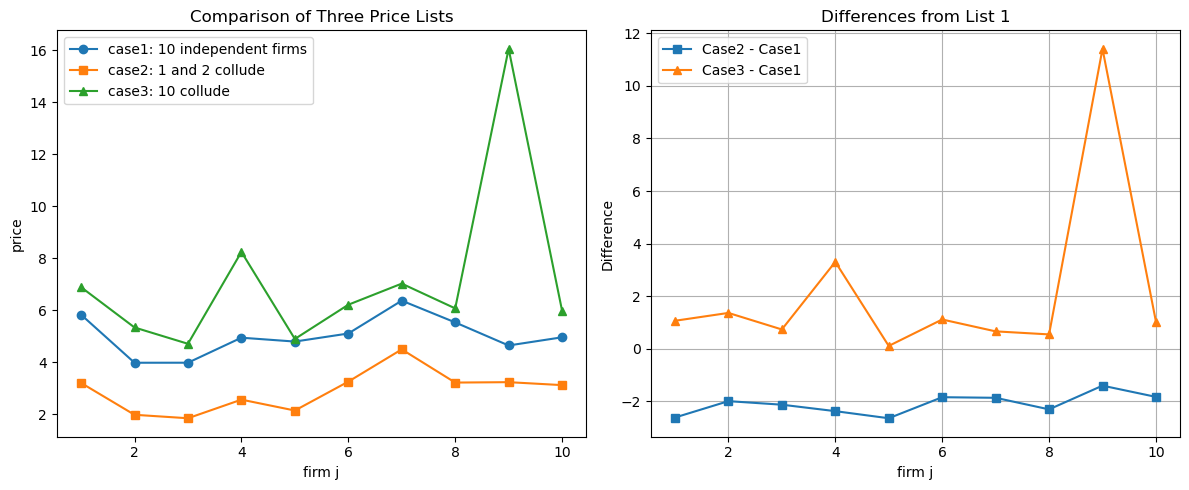

In [36]:
def calc_profit(temp_price):
    s_list = share_function_MNL(temp_price)
    pi = [0]
    for j in range(1, 11):
        # print(j,temp_price[j-1],c_jt_dic[(j,Temp_t)],s_list[j-1])
        pi.append((temp_price[j-1]-c_jt_dic[(j, Temp_t)])*(s_list[j-1]))
    return pi


def loss_total_profit(p):
    return -1 * np.sum(calc_profit(p))


# step 2: I directly search for optimal p vector that maximizes the total profit. It gives an almost perfect answer, but since the tolerance is quite high, I just use it as a clever initial guess for Nash solver (GMM).
initial_guess = list(data[data['t'] == 100]['price'])
result = minimize(loss_total_profit, initial_guess,
                  tol=1e-3, method='Nelder-Mead')
# here if set tol =1e-4 then it performs quite well. Then no place for my Nash Solver, not cool.
paint(price_star, price_star_q2, result.x)

In [37]:
result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -2.988659815577282
             x: [ 6.882e+00  5.332e+00  4.704e+00  8.240e+00  4.890e+00
                  6.207e+00  7.019e+00  6.066e+00  1.605e+01  5.979e+00]
           nit: 1409
          nfev: 2000
 final_simplex: (array([[ 6.882e+00,  5.332e+00, ...,  1.605e+01,
                         5.979e+00],
                       [ 6.885e+00,  5.346e+00, ...,  1.606e+01,
                         5.980e+00],
                       ...,
                       [ 6.894e+00,  5.362e+00, ...,  1.607e+01,
                         5.981e+00],
                       [ 6.891e+00,  5.345e+00, ...,  1.607e+01,
                         5.980e+00]]), array([-2.989e+00, -2.989e+00, -2.989e+00, -2.989e+00,
                       -2.989e+00, -2.989e+00, -2.989e+00, -2.989e+00,
                       -2.989e+00, -2.989e+00, -2.989e+00]))

number of iterations for minimize kernal: 1398


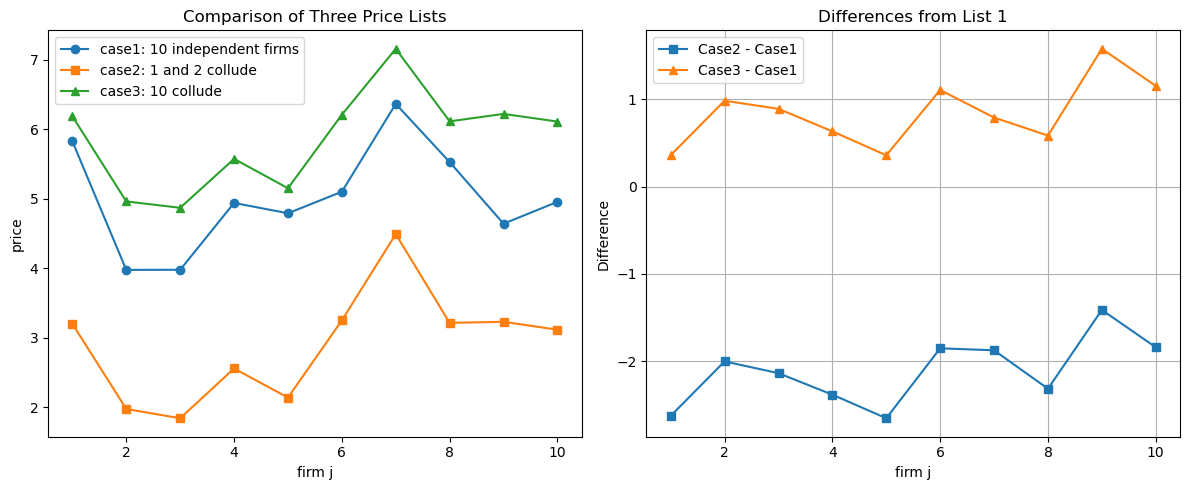

[6.18537398 4.95988094 4.86834217 5.57243777 5.14970356 6.20822487
 7.15700594 6.11264073 6.21969209 6.10972981]


In [38]:
# step 3: Use theory_optimal_price as an initial guess for GMM solver. Finally I get price_star_q3_prime which is even better than theory_xx.
optimal_profit = np.sum(calc_profit(result.x))
global theory_optimal_price
theory_optimal_price = result.x

price_star_q3_prime, result_q3_prime = solve_Nash(
    initial_guess=theory_optimal_price, question=3)
paint(price_star, price_star_q2, price_star_q3_prime)
# and the optimal price_star for 10-collusion is price_star_q3_prime
print(price_star_q3_prime)

In [39]:
pi_q1 = calc_profit(price_star)
pi_q2 = calc_profit(price_star_q2)
pi_q3 = calc_profit(price_star_q3_prime)
pi_q3_prime = calc_profit(price_star_q3_prime)
judge_q2profitable = pi_q1[1]+pi_q1[2] <= pi_q2[1]+pi_q2[2]
judge_q3profitable = np.sum(pi_q1) <= np.sum(pi_q3)

print(judge_q2profitable, (pi_q2[1]+pi_q2[2])/pi_q1[1]+pi_q1[2])
print(judge_q3profitable, np.sum(pi_q3)/np.sum(pi_q1))
# So my results say :
# If 1 and 2 collude then both firm's profit increases by 20%
# If all firms collude then the total profit increases by 237%.

False 0.7870844966860501
True 1.1530992602667285


### <a id='toc4_3_1_'></a>[Answer for 3(c):](#toc0_)
After the merging of 1 and 2, prices generally increases a little bit since there is less competition. Firm 2 increases the most, since its share is very small compared to 1.

The increase in the same nest is larger, since the drop of competition is larger within the same nest. Also it's because the original price is generally lower in Diet nest.

Competing products from different nests also increase their price, but with lower rate.



In [40]:
dic_compare = {}
dic_compare['Competetion'] = price_star
dic_compare['Merging 1_2'] = price_star_q2
dic_compare['Merging 10'] = price_star_q3_prime
df = pd.DataFrame(dic_compare)
df['case2/case1:Increase By Percent'] = (
    df['Merging 1_2']/df['Competetion']-1)*100
df['case3/case1:Increase By Percent'] = (
    df['Merging 10']/df['Competetion']-1)*100
df.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
group = data[data['t'] == 1][['product_ID', 'nest']].set_index('product_ID')
df['nest'] = group['nest']
df.round(2)

,Competetion,Merging 1_2,Merging 10,case2/case1:Increase By Percent,case3/case1:Increase By Percent,nest
1,5.82,3.20,6.19,-45.10,6.21,Diet
2,3.97,1.97,4.96,-50.38,24.80,Diet
3,3.98,1.84,4.87,-53.76,22.45,Diet
4,4.94,2.55,5.57,-48.26,12.84,Diet
5,4.79,2.14,5.15,-55.41,7.52,Diet
6,5.10,3.25,6.21,-36.32,21.74,Regular
7,6.36,4.49,7.16,-29.46,12.45,Regular
8,5.53,3.21,6.11,-41.89,10.60,Regular
9,4.64,3.23,6.22,-30.44,34.07,Regular
10,4.95,3.11,6.11,-37.15,23.33,Regular


In [41]:
df.groupby('nest').agg('mean')

,Competetion,Merging 1_2,Merging 10,case2/case1:Increase By Percent,case3/case1:Increase By Percent
nest,,,,,
Diet,4.700308,2.339739,5.347148,-50.580638,14.76440
Regular,5.316738,3.457857,6.361459,-35.050593,20.43964
